In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import math
import sklearn
import sklearn.datasets

from opt_utils import load_params_and_grads, initialize_parameters, forward_propagation, backward_propagation
from opt_utils import compute_cost, predict, predict_dec, plot_decision_boundary, load_dataset
from testCases import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (7.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

/home/zhiyu/study/deeplearning.ai-andrewNG-master/COURSE 2 Improving Deep Neural Networks Hyperparameter tuning, Regularization and Optimization/week 02/opt_utils.py:76: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(parameters['W' + str(l)].shape == layer_dims[l], layer_dims[l-1])
/home/zhiyu/study/deeplearning.ai-andrewNG-master/COURSE 2 Improving Deep Neural Networks Hyperparameter tuning, Regularization and Optimization/week 02/opt_utils.py:77: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(parameters['W' + str(l)].shape == layer_dims[l], 1)


In [13]:
def update_parameters_with_gd(parameters, grads, learning_rate):
    
    L = len(parameters) // 2
    
    for i in range(L):
        
        parameters['W' + str(i + 1)] -= learning_rate * grads['dW' + str(i + 1)]
        parameters['b' + str(i + 1)] -= learning_rate * grads['db' + str(i + 1)]
    
    return parameters

In [3]:
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    
    np.random.seed(seed)
    m = X.shape[1]
    mini_batches = []
    
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((1, m))
    
    num_complete_minibatches = math.floor(m / mini_batch_size)
    for k in range(0, num_complete_minibatches):
        
        mini_batch_X = shuffled_X[:, k * mini_batch_size : (k + 1) * mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k * mini_batch_size : (k + 1) * mini_batch_size]
        
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    if m % mini_batch_size != 0:
        
        mini_batch_X = shuffled_X[:, k * mini_batch_size : (k + 1) * mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k * mini_batch_size : (k + 1) * mini_batch_size]
        
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [4]:
X_assess, Y_assess, mini_batch_size = random_mini_batches_test_case()
mini_batches = random_mini_batches(X_assess, Y_assess, mini_batch_size)

print ("shape of the 1st mini_batch_X: " + str(mini_batches[0][0].shape))
print ("shape of the 2nd mini_batch_X: " + str(mini_batches[1][0].shape))
print ("shape of the 3rd mini_batch_X: " + str(mini_batches[2][0].shape))
print ("shape of the 1st mini_batch_Y: " + str(mini_batches[0][1].shape))
print ("shape of the 2nd mini_batch_Y: " + str(mini_batches[1][1].shape)) 
print ("shape of the 3rd mini_batch_Y: " + str(mini_batches[2][1].shape))
print ("mini batch sanity check: " + str(mini_batches[0][0][0][0:3]))

shape of the 1st mini_batch_X: (12288, 64)
shape of the 2nd mini_batch_X: (12288, 64)
shape of the 3rd mini_batch_X: (12288, 64)
shape of the 1st mini_batch_Y: (1, 64)
shape of the 2nd mini_batch_Y: (1, 64)
shape of the 3rd mini_batch_Y: (1, 64)
mini batch sanity check: [ 0.90085595 -0.7612069   0.2344157 ]


In [5]:
def initialize_velocity(parameters):
    
    L = len(parameters) // 2
    v = {}
    
    for i in range(L):
        
        v['dW' + str(i + 1)] = np.zeros(parameters['W' + str(i + 1)].shape)
        v['db' + str(i + 1)] = np.zeros(parameters['b' + str(i + 1)].shape)
        
    return v

In [6]:
def update_parameters_with_momentum(parameters, grads, v, beta, learning_rate):
    
    L = len(parameters) // 2
    
    for i in range(L):
        
        v['dW' + str(i + 1)] = beta * v['dW' + str(i + 1)] + (1 - beta) * grads['dW' + str(i + 1)]
        v['db' + str(i + 1)] = beta * v['db' + str(i + 1)] + (1 - beta) * grads['db' + str(i + 1)]
        
        parameters['W' + str(i + 1)] -= learning_rate * v['dW' + str(i + 1)]
        parameters['b' + str(i + 1)] -= learning_rate * v['db' + str(i + 1)]
    
    return parameters, v

In [7]:
def initialize_adam(parameters):
    
    L = len(parameters) // 2
    v = {}
    s = {}
    
    for i in range(L):
        
        v["dW" + str(i + 1)] = np.zeros(parameters["W" + str(i + 1)].shape)
        v["db" + str(i + 1)] = np.zeros(parameters["b" + str(i + 1)].shape)
        s["dW" + str(i + 1)] = np.zeros(parameters["W" + str(i + 1)].shape)
        s["db" + str(i + 1)] = np.zeros(parameters["b" + str(i + 1)].shape)
        
    return v, s

In [8]:
def update_parameters_with_adam(parameters, grads, v, s, t, learning_rate = 0.01,
                               beta1 = 0.9, beta2 = 0.999, epsilon = 1e-8):
    
    L = len(parameters) // 2
    v_corrected = {}
    s_corrected = {}
    
    for i in range(L):
        
        v["dW" + str(i + 1)] = beta1 * v["dW" + str(i + 1)] + (1 - beta1) * grads["dW" + str(i + 1)]
        v["db" + str(i + 1)] = beta1 * v["db" + str(i + 1)] + (1 - beta1) * grads["db" + str(i + 1)]
        
        v_corrected["dW" + str(i + 1)] = v["dW" + str(i + 1)] / (1 - beta1 ** t)
        v_corrected["db" + str(i + 1)] = v["db" + str(i + 1)] / (1 - beta1 ** t)
        
        s["dW" + str(i + 1)] = beta2 * s["dW" + str(i + 1)] + (1 - beta2) * np.multiply(grads["dW" + str(i + 1)], grads["dW" + str(i + 1)])
        s["db" + str(i + 1)] = beta2 * s["db" + str(i + 1)] + (1 - beta2) * np.multiply(grads["db" + str(i + 1)], grads["db" + str(i + 1)])
        
        s_corrected["dW" + str(i + 1)] = s["dW" + str(i + 1)] / (1 - beta2 ** t)
        s_corrected["db" + str(i + 1)] = s["db" + str(i + 1)] / (1 - beta2 ** t)
        
        parameters["W" + str(i + 1)] -= learning_rate * v_corrected["dW" + str(i + 1)] / (epsilon + np.sqrt(s_corrected["dW" + str(i + 1)]))
        parameters["b" + str(i + 1)] -= learning_rate * v_corrected["db" + str(i + 1)] / (epsilon + np.sqrt(s_corrected["db" + str(i + 1)]))
        
    return parameters, v, s

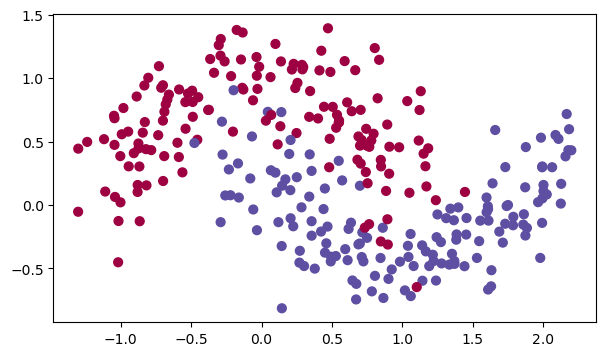

In [9]:
train_X, train_Y = load_dataset()

In [18]:
def model(X, Y, layers_dims, optimizer, learning_rate = 0.0007, mini_batch_size = 64, beta = 0.9,
         beta1 = 0.9, beta2 = 0.999, epsilon = 1e-8, num_epochs = 10000, print_cost = True):
    
    L = len(layers_dims)
    costs = []
    t = 0
    seed = 10
    
    parameters = initialize_parameters(layers_dims)
    
    if optimizer == "gd":
        pass
    elif optimizer == "momentum":
        v = initialize_velocity(parameters)
    elif optimizer == "adam":
        v, s = initialize_adam(parameters)
    
    for i in range(num_epochs):
        
        seed = seed + 1
        minibatches = random_mini_batches(X, Y, mini_batch_size, seed)
        
        for minibatch in minibatches:
            
            (minibatch_X, minibatch_Y) = minibatch
            
            a3, caches = forward_propagation(minibatch_X, parameters)
            
            cost = compute_cost(a3, minibatch_Y)
            
            grads = backward_propagation(minibatch_X, minibatch_Y, caches)
            
            if optimizer == "gd":
                parameters = update_parameters_with_gd(parameters, grads, learning_rate)
            elif optimizer == "momentum":
                parameters, v = update_parameters_with_momentum(parameters, grads, v, beta, learning_rate)
            elif optimizer == "adam":
                t = t + 1
                paramters, v, s = update_parameters_with_adam(parameters, grads, v, s,
                                                             t, learning_rate, beta1, beta2, epsilon)
            
        if print_cost and i % 1000 == 0:
            print("Cost after epoch %i: %f" %(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
        
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('epochs (per 100)')
    plt.title("Learning rate = " + str(learning_rate))
    plt.show()
    
    return parameters

In [11]:
def plot_decision_boundary(model, X, y):
    
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    h = 0.01
    
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    plt.contourf(xx, yy, Z, cmp=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    y = y.reshape(X[0, :].shape)
    plt.scatter(X[0, :], X[1, :], c=y, cmap=plt.cm.Spectral)
    plt.show()

Cost after epoch 0: 0.690034
Cost after epoch 1000: 0.666976
Cost after epoch 2000: 0.633505
Cost after epoch 3000: 0.591708
Cost after epoch 4000: 0.582475
Cost after epoch 5000: 0.546573
Cost after epoch 6000: 0.504263
Cost after epoch 7000: 0.570703
Cost after epoch 8000: 0.499480
Cost after epoch 9000: 0.494540


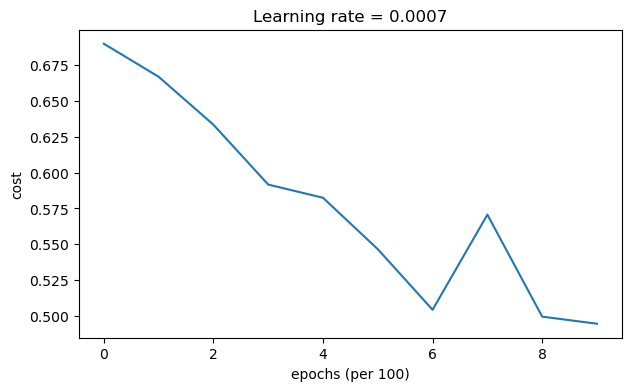

Accuracy: 0.7966666666666666


/tmp/ipykernel_4452/3858706409.py:12: UserWarning: The following kwargs were not used by contour: 'cmp'
  plt.contourf(xx, yy, Z, cmp=plt.cm.Spectral)


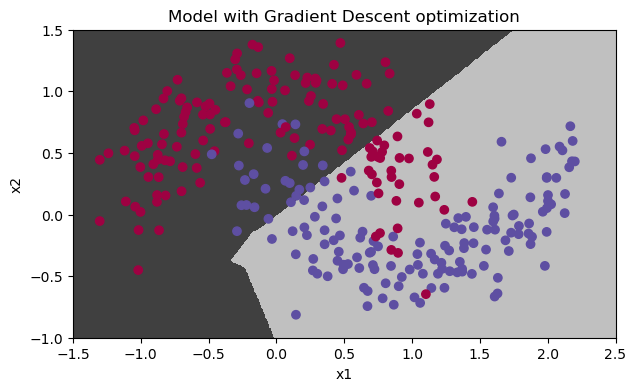

In [14]:
layers_dims = [train_X.shape[0], 5, 2, 1]
parameters =model(train_X, train_Y, layers_dims, optimizer = 'gd')

predictions = predict(train_X, train_Y, parameters)

plt.title("Model with Gradient Descent optimization")
axes = plt.gca()
axes.set_xlim([-1.5,2.5])
axes.set_ylim([-1,1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

Cost after epoch 0: 1.366216
Cost after epoch 1000: 0.554944
Cost after epoch 2000: 0.399136
Cost after epoch 3000: 0.331835
Cost after epoch 4000: 0.422219
Cost after epoch 5000: 0.470249
Cost after epoch 6000: 0.300394
Cost after epoch 7000: 0.369801
Cost after epoch 8000: 0.324803
Cost after epoch 9000: 0.379908


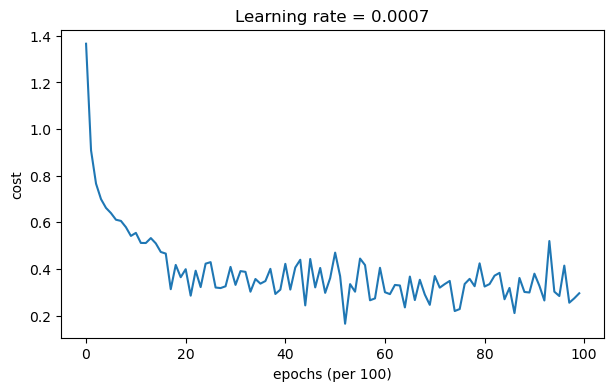

Accuracy: 0.8866666666666667


/tmp/ipykernel_4452/3858706409.py:12: UserWarning: The following kwargs were not used by contour: 'cmp'
  plt.contourf(xx, yy, Z, cmp=plt.cm.Spectral)


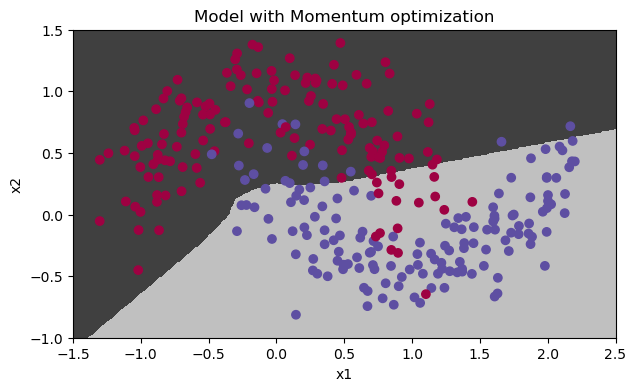

In [19]:
layers_dims = [train_X.shape[0], 15, 4, 1]
parameters = model(train_X, train_Y, layers_dims, beta = 0.9, optimizer = "momentum")

# Predict
predictions = predict(train_X, train_Y, parameters)

# Plot decision boundary
plt.title("Model with Momentum optimization")
axes = plt.gca()
axes.set_xlim([-1.5,2.5])
axes.set_ylim([-1,1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

Cost after epoch 0: 0.689996
Cost after epoch 1000: 0.125975
Cost after epoch 2000: 0.148672
Cost after epoch 3000: 0.166645
Cost after epoch 4000: 0.238660
Cost after epoch 5000: 0.147871
Cost after epoch 6000: 0.119363
Cost after epoch 7000: 0.154122
Cost after epoch 8000: 0.131885
Cost after epoch 9000: 0.170206


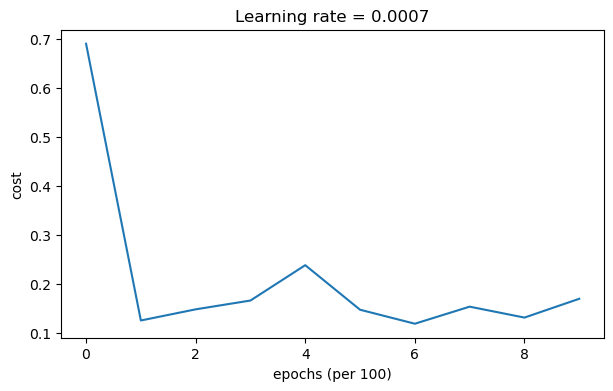

Accuracy: 0.94


/tmp/ipykernel_4452/3858706409.py:12: UserWarning: The following kwargs were not used by contour: 'cmp'
  plt.contourf(xx, yy, Z, cmp=plt.cm.Spectral)


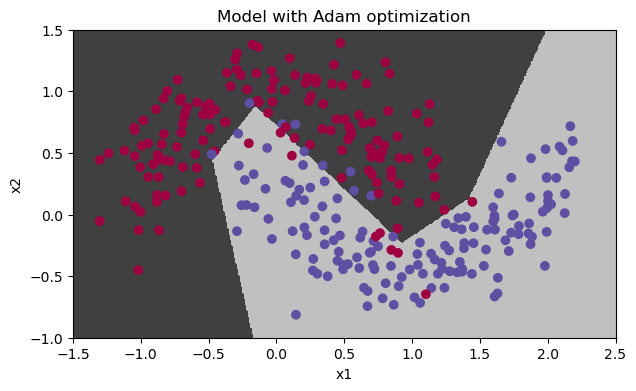

In [17]:
layers_dims = [train_X.shape[0], 5, 2, 1]
parameters = model(train_X, train_Y, layers_dims, optimizer = "adam")

# Predict
predictions = predict(train_X, train_Y, parameters)

# Plot decision boundary
plt.title("Model with Adam optimization")
axes = plt.gca()
axes.set_xlim([-1.5,2.5])
axes.set_ylim([-1,1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)